### We start by importing the data and viewing it

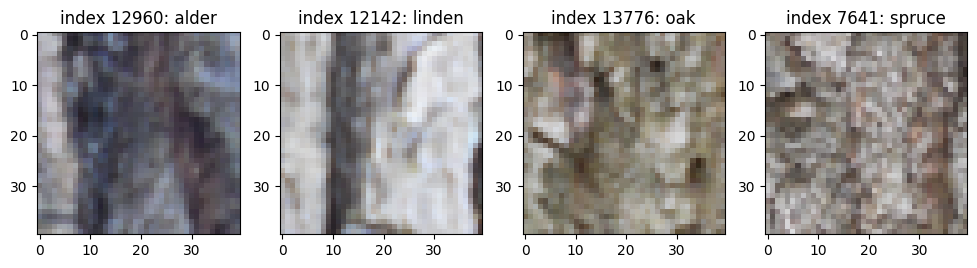

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter # Useful for checking class distributions from labels

# This is a standard definition for a custom dataset that is needed for DataLoader
class CustomDataset:
    def __init__(self, images=None, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Helper method for extracting images and labels for our custom data (Data was exported from matlab)
def GetImagesAndLabels(imgPath, labelPath):
    # Read images from HDF5 file
    with h5py.File(imgPath, "r") as f:
        images = np.array(f["data"]) # Get data
        images = [np.transpose(images[i], (2, 1, 0)) for i in range(len(images) )] # Rearrange dimensions
    # Read labels from HDF5 file
    with h5py.File(labelPath, "r") as f:
        labels = np.array(f["labels"]) # Get labels
        # Convert to array of 0 indexed integers
        labels = labels[0].astype(int) - 1
    return images, labels

# Get training data
train_images, train_labels = GetImagesAndLabels("traindata.h5","trainlabels.h5")
# Divide 10% training data into evaluation data with stratification of classes and random sampling
train_images, eval_images, train_labels, eval_labels = train_test_split(
        train_images, train_labels, test_size=0.1, stratify=train_labels, random_state=42)
# Get test data
test_images, test_labels = GetImagesAndLabels("testdata.h5","testlabels.h5")
# Define the classes for train and test data
classes = ["alder", "beech", "birch", "chestnut", "ginkgo biloba", "hornbeam", "horse chestnut", "linden", "oak", "oriental plane", "pine", "spruce"]

# Get ood_id data
ood_id_images, ood_id_labels = GetImagesAndLabels("ood_iddata.h5","ood_idlabels.h5")
# Define the classes for ood_id data
ood_id_classes = ["id","ood"]

# Put datasets into our custom data structure, we'll define the transformers later
train_data = CustomDataset(train_images,train_labels)
test_data = CustomDataset(test_images,test_labels)
eval_data = CustomDataset(eval_images,eval_labels)


# Plot some training images (zero indexed, so in matlab add 1 to the indeces to compare)
fig = plt.figure(figsize=(12, 7)) 
for i in range(1,5):
    fig.add_subplot(1, 4, i) 
    # Select random index
    j = random.randint(0, len(train_images) - 1)
    classname = classes[train_labels[j]]
    plt.imshow(train_images[j])
    plt.title(f"index {j}: {classname}")

### We can do some pre-processing to the data here

100%|██████████████████████████████████████████████████████████████████████████| 13867/13867 [00:03<00:00, 4351.00it/s]


RGB - standard deviation:[36.55354537 37.87313231 39.76296257] | mean: [143.47162666 139.36865102 133.09146855]


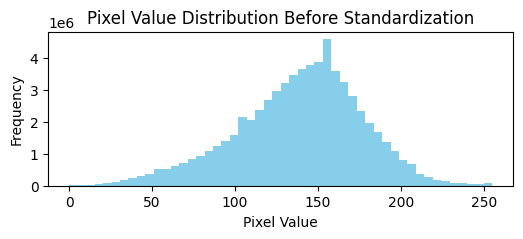

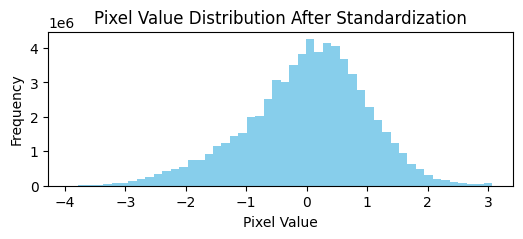

In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
from tqdm import tqdm

# Plot the distributions of an array of pixels
def VisualizePixelDistribution(pixels, title, savePath):
    pixels = np.array(pixels)
    plt.figure(figsize=(6, 2))
    plt.title(title)
    plt.hist(pixels.ravel(), bins=50, color="skyblue")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.savefig(savePath)

# Calculate mean and standard deviation of each color channel in training data
def CalculateStandardizationVals():
    trainImages = np.array(train_data.images) # Make sure that train_data was defined in the previous cell
    pixels = []
    # Flatten structure so we have an array of pixels
    for image in tqdm(trainImages):
        pixels.extend(image.reshape(-1,3))

    # see how the pixels are distributed before standardizing
    VisualizePixelDistribution(pixels,"Pixel Value Distribution Before Standardization","pixelDensityBefore.pdf")
    
    # Fit a standard scaler to each channel which represents a feature here, this calculates variance and mean for us
    scaler = StandardScaler().fit(pixels)
    
    # view the pixel distribution after standardization
    standardized_pixels = scaler.transform(pixels)
    VisualizePixelDistribution(standardized_pixels,"Pixel Value Distribution After Standardization","pixelDensityAfter.pdf")
    
    return np.sqrt(scaler.var_), scaler.mean_ # We just want to return the calculated values

# Uncomment to recalculate std and mean (Takes a minute)
std, mean = CalculateStandardizationVals()
print(f"RGB - standard deviation:{std} | mean: {mean}")

# Transformer to not do any pre-processing
transformSimple = transforms.Compose([
    transforms.ToTensor()
])

# Transformer to standardize the data
transformStandardized = transforms.Compose([
    transforms.ToTensor(), # This normalizes the pixel values
    transforms.Normalize(mean=mean/255, std=std/255) # So we have to divide mean and std by 255 as well
])

# Sets transformer on datasets and then converts them to loaders
def GetDataLoaders(train_data, test_data, eval_data, transformer, batch_size=32):
    # Duplicate data structures
    train = deepcopy(train_data)
    test = deepcopy(test_data)
    eval = deepcopy(eval_data)
    
    # Add the new transformer
    train.transform = transformer
    test.transform = transformer
    eval.transform = transformer
    
    # Create data loaders
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)
    eval_loader = DataLoader(eval, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, eval_loader

# Create dataloaders - We're using these because they make data operations much easier
train_loader, test_loader, eval_loader = GetDataLoaders(train_data, test_data, eval_data, transformSimple)
standardized_train_loader, standardized_test_loader, standardized_eval_loader = GetDataLoaders(train_data, test_data, eval_data, transformStandardized)

### let's define a base model that we can improve on, we're using convolutional layers, connected layers, and some regularization

In [3]:
import torch # We're using pytorch
import torchvision
import torch.nn as nn
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential( #3x40x40
            nn.Conv2d(3, 20, kernel_size=4, padding=2), # 20x40x40
            nn.MaxPool2d(2), # 20x20x20
            nn.ReLU(),
            nn.Conv2d(20, 40, kernel_size=4, padding=2), # 40x20x20
            nn.MaxPool2d(2), #40x10x10
            nn.ReLU(),
            nn.Conv2d(40, 60, kernel_size=4, padding=2), # 60x10x10
            nn.MaxPool2d(2), #60x5x5
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(60*5*5, 50),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(50, 12) # Multi classification
        )
        
    def forward(self, x):
        return self.model(x)

### Next we need to create the functions to train the model

In [4]:
from tqdm import tqdm # Progress bar
# Train one epoch of a model
def trainOneEpoch(model, dataloader, criterion, optimizer, device):
    model.train()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    # Train
    for inputs, labels in dataloader:
        # Move data to device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)
        # Reset gradients
        optimizer.zero_grad()
        # Perform predictions
        outputs = model(inputs)
        # Calculate loss
        labels = labels.long()
        loss = criterion(outputs, labels)
        # Perform backwards propagation
        loss.backward()
        # Update model
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        # Add predictions and labels to lists and move them to cpu
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_accuracy = accuracy_score(all_labels, all_preds)
    epoch_loss = running_loss / len(dataloader)  # Average loss
    return epoch_accuracy, epoch_loss

In [5]:
# Train a model for a number of epochs
def trainModel(model, trainLoader,valLoader, numEpochs, criterion, optimizer, device, earlyStopping, savePath=None):
    model.to(device) # Move model to device (GPU or CPU)
    lowest_eval_loss = np.inf
    early_stop_counter = 0
    # Record evaluation history during training
    history = {
    "training_accuracy": [],
    "evaluation_accuracy": []
    }
    for epoch in range(numEpochs):
        # Train one epoch, get accuracy and loss on training data
        train_accuracy, train_loss = trainOneEpoch(model, trainLoader, criterion, optimizer, device)
        # Evaluate on evaluation set
        eval_accuracy, eval_loss = evaluateModel1(model, valLoader, criterion, device)
        # Add evaluation accuracies to history
        history["training_accuracy"].append(train_accuracy)
        history["evaluation_accuracy"].append(eval_accuracy)
        # Print epoch info
        print(f"Epoch [{epoch+1}/{numEpochs}], Training Accuracy: {train_accuracy:.4f}, Average Loss: {train_loss:.4f} | Evaluation Accuracy: {eval_accuracy:.4f} Loss:{eval_loss:.4f}")
        # Perform early stopping if earlyStopping value is valid (>= 0)
        if earlyStopping >= 0:
            # Check if evaluation loss is smaller than previously
            if eval_loss < lowest_eval_loss:
                # Reset counter
                lowest_eval_loss = eval_loss
                early_stop_counter = 0
            else:
                # One step close to stopping
                early_stop_counter += 1
            if early_stop_counter > earlyStopping:
                # Stop training
                print(f"Stopped early at Epoch {epoch} after {earlyStopping + 1} successive epochs with no improvement")
                break
    # Save model if savepath is defined
    if savePath:
        torch.save(model.state_dict(), savePath + ".pth")
        print("Finished training and saved model")
    else:
        print("Finished training")
    return model, history

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
# Plots a confusion matrix based on integer labels and predictions, and represents them with classNames (strings)
def plotConfusionMatrix(labels, predictions, classNames, savePath=None):
    # Create the confusion matrix
    cm = confusion_matrix(labels, predictions)
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classNames)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45,ha="right")
    plt.tight_layout()
    # Save figure if savePath is defined
    if savePath:
        plt.savefig(savePath)
    plt.show()

# Evaluates accuracy and average loss, and returns all predictions and labels
def evaluateModelHelper(model, valLoader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Pass inputs through model
            outputs = model(inputs)
            # Calculate loss
            labels = labels.long()
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0) # Multiply loss with batch size
            # Predict maximum value as predicted class
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    average_loss = total_loss / len(valLoader.dataset)
    return accuracy, average_loss, all_preds, all_labels

# Evaluate a model with accuracy and average loss
def evaluateModel1(model, valLoader, criterion, device):
    accuracy, average_loss, _, _ = evaluateModelHelper(model, valLoader, criterion, device)
    return accuracy, average_loss
    
# Evaluate a model with accuracy, average_loss, precision, recall, and f1 scores, and plot confusion matrix
def evaluateModel2(model, valLoader, criterion, device, savePath=None):
    accuracy, average_loss, all_preds, all_labels = evaluateModelHelper(model, valLoader, criterion, device)
    precision = precision_score(all_labels, all_preds,average="macro",zero_division=0)
    recall = recall_score(all_labels, all_preds,average="macro")
    f1 = f1_score(all_labels, all_preds,average="macro")
    plotConfusionMatrix(all_labels, all_preds, classes, savePath)
    return accuracy, average_loss, precision, recall, f1

In [7]:
# Plots training history as defined in trainModel()
def plotTrainingHistory(history, savePath=None):
    plt.figure(figsize=(8, 4))
    epochs = range(1, len(history["training_accuracy"]) + 1)
    plt.plot(epochs, history["training_accuracy"], label="Training Accuracy")
    plt.plot(epochs, history["evaluation_accuracy"], label="Evaluation Accuracy")
    plt.title("Training and Evaluation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.ylim(0, 1)
    # Save figure if savePath is defined
    if savePath:
        plt.savefig(savePath)
    plt.show()

In [9]:
import torch.optim as optim
# Train a model and evaluate it
def trainModelAndEvaluate(model, trainLoader, valLoader, testLoader, device, earlyStopping, savePath=None):
    # Initialize criterion, optimizer, number of epochs
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    numEpochs = 2
    # Train the model; save it if savePath is defined
    model, history = trainModel(model, trainLoader,valLoader, numEpochs, criterion, optimizer, device, earlyStopping, savePath)
    # Save history and confusion matrix if savePath is valid; otherwise just print/plot the data
    if(savePath):
        plotTrainingHistory(history,savePath + "_history.pdf")
        # Perform final evaluation on test-set and show + save confusion matrix
        accuracy, loss, precision, recall, f1  = evaluateModel2(model, testLoader, criterion, device, savePath + "_confusionMatrix.pdf")
    else:
        plotTrainingHistory(history)
        # Perform final evaluation on test-set and show confusion matrix
        accuracy, loss, precision, recall, f1  = evaluateModel2(model, testLoader, criterion, device)
    
    print("\nTest Set Evaluation")
    print(f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-Score: {f1:.4f}\nLoss:{loss:.4f}")

### let's train our base model

Epoch [1/2], Training Accuracy: 0.1546, Average Loss: 2.3147 | Evaluation Accuracy: 0.2330 Loss:2.0621
Epoch [2/2], Training Accuracy: 0.2274, Average Loss: 2.0559 | Evaluation Accuracy: 0.2654 Loss:1.9114
Finished training and saved model


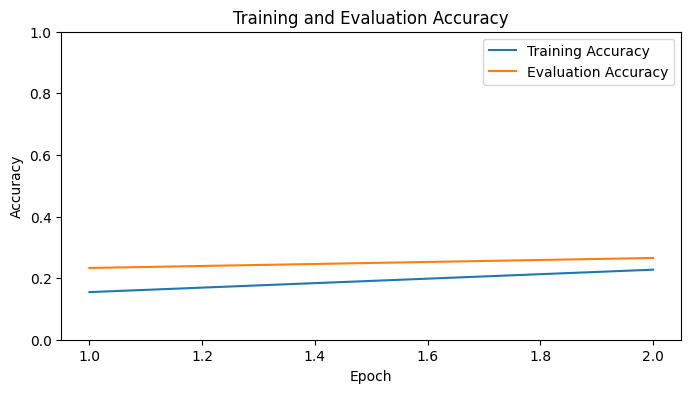

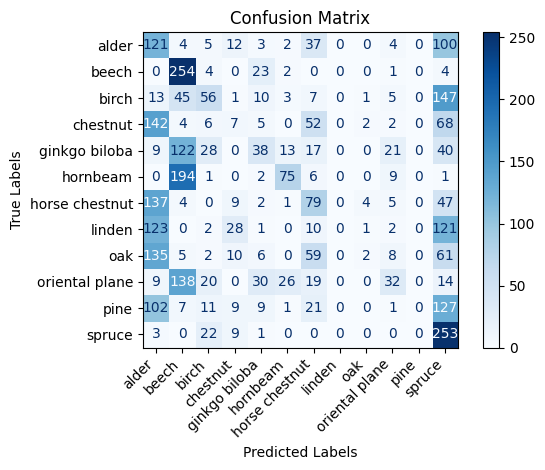


Test Set Evaluation
Accuracy: 0.2653
Precision: 0.2409
Recall: 0.2653
F1-Score: 0.1986
Loss:1.9450


In [10]:
model = SimpleCNN()
device = torch.device("cuda")
trainModelAndEvaluate(model, train_loader, eval_loader, test_loader, device, -1, "simple_cnn")

### let's try adding batch normalization layers, data pre-processing, and early stopping to see how much we can improve

Epoch [1/2], Training Accuracy: 0.4256, Average Loss: 1.7166 | Evaluation Accuracy: 0.5425 Loss:1.3289
Epoch [2/2], Training Accuracy: 0.5990, Average Loss: 1.2004 | Evaluation Accuracy: 0.7073 Loss:0.8973
Finished training and saved model


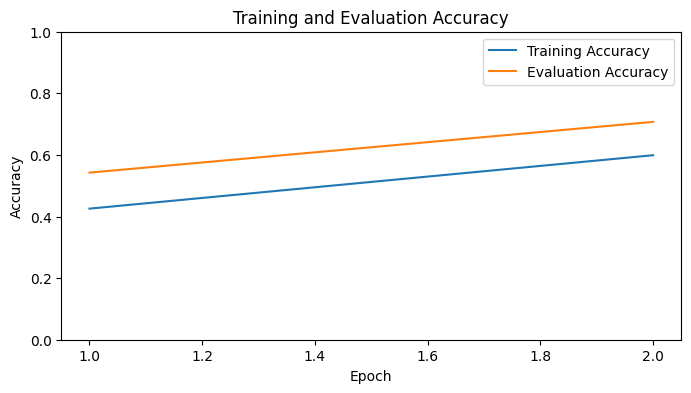

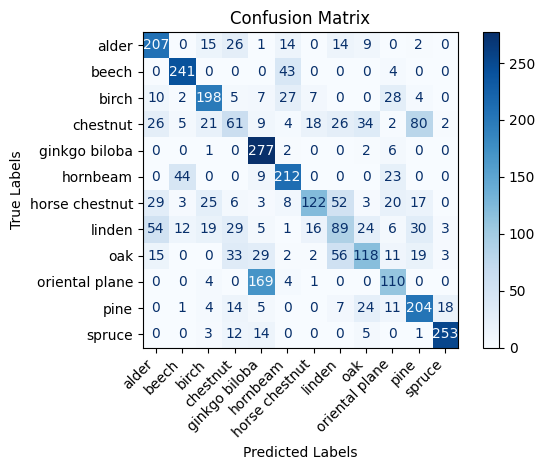


Test Set Evaluation
Accuracy: 0.6053
Precision: 0.6007
Recall: 0.6053
F1-Score: 0.5903
Loss:1.0930


In [11]:
import torch # We're using pytorch
import torchvision
import torch.nn as nn
class BatchNormalizationCNN(torch.nn.Module):
    def __init__(self):
        super(BatchNormalizationCNN, self).__init__()
        self.model = nn.Sequential( #3x40x40
            nn.Conv2d(3, 20, kernel_size=4, padding=2), # 20x40x40
            nn.MaxPool2d(2), # 20x20x20
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Conv2d(20, 40, kernel_size=4, padding=2), # 40x20x20
            nn.MaxPool2d(2), #40x10x10
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.Conv2d(40, 60, kernel_size=4, padding=2), # 60x10x10
            nn.MaxPool2d(2), #60x5x5
            nn.BatchNorm2d(60),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(60*5*5, 50),
            nn.BatchNorm1d(50),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(50, 12) # Multi classification
        )
        
    def forward(self, x):
        return self.model(x)
model = BatchNormalizationCNN()
device = torch.device("cuda")
trainModelAndEvaluate(model, standardized_train_loader, standardized_eval_loader, standardized_test_loader, device, 5, "full_cnn_notused")

### let's perform an ablation study on this model to see how the model fairs without image pre-processing, batch normalization, and early stopping

#### Model without image pre-processing

Epoch [1/2], Training Accuracy: 0.4185, Average Loss: 1.6964 | Evaluation Accuracy: 0.3335 Loss:2.1421
Epoch [2/2], Training Accuracy: 0.5822, Average Loss: 1.2375 | Evaluation Accuracy: 0.2356 Loss:3.9114
Finished training and saved model


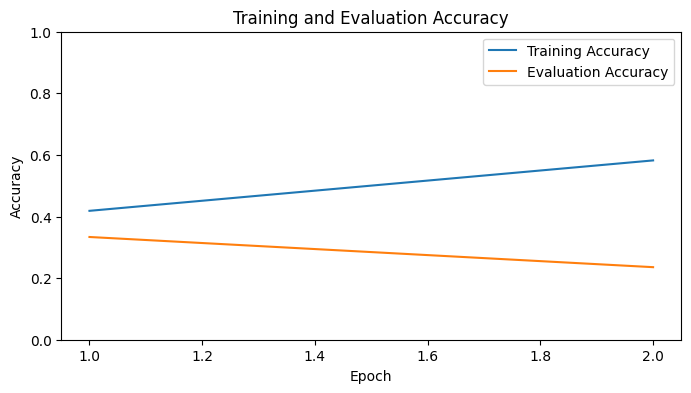

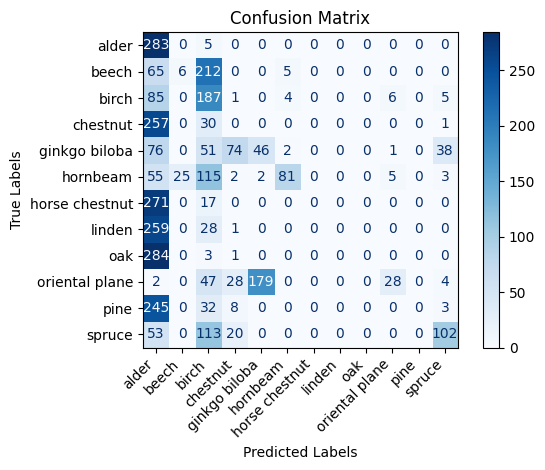


Test Set Evaluation
Accuracy: 0.2121
Precision: 0.2499
Recall: 0.2121
F1-Score: 0.1549
Loss:3.9881


In [12]:
import torch # We're using pytorch
import torchvision
import torch.nn as nn
class BatchNormalizationCNN(torch.nn.Module):
    def __init__(self):
        super(BatchNormalizationCNN, self).__init__()
        self.model = nn.Sequential( #3x40x40
            nn.Conv2d(3, 20, kernel_size=4, padding=2), # 20x40x40
            nn.MaxPool2d(2), # 20x20x20
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Conv2d(20, 40, kernel_size=4, padding=2), # 40x20x20
            nn.MaxPool2d(2), #40x10x10
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.Conv2d(40, 60, kernel_size=4, padding=2), # 60x10x10
            nn.MaxPool2d(2), #60x5x5
            nn.BatchNorm2d(60),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(60*5*5, 50),
            nn.BatchNorm1d(50),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(50, 12) # Multi classification
        )
        
    def forward(self, x):
        return self.model(x)
model = BatchNormalizationCNN()
device = torch.device("cuda")
trainModelAndEvaluate(model, train_loader, eval_loader, test_loader, device, 5, "noImgProcessing_cnn")

#### Model without batch normalization

Epoch [1/2], Training Accuracy: 0.2593, Average Loss: 2.0875 | Evaluation Accuracy: 0.3744 Loss:1.6545
Epoch [2/2], Training Accuracy: 0.3609, Average Loss: 1.7493 | Evaluation Accuracy: 0.4724 Loss:1.5634
Finished training and saved model


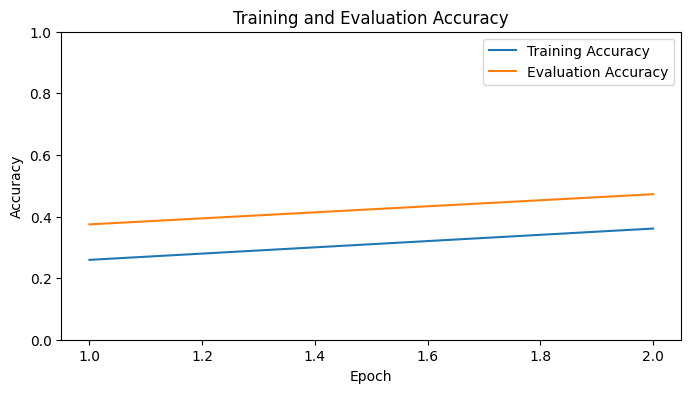

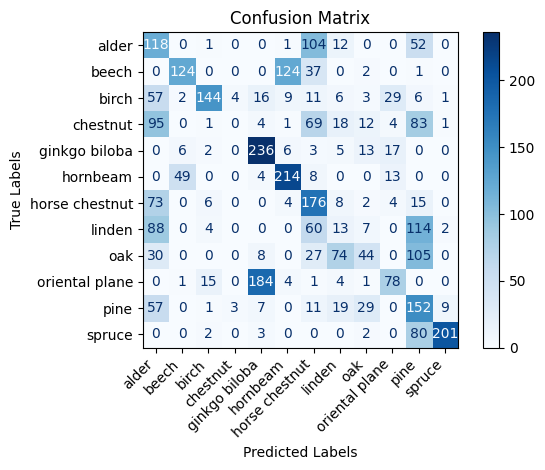


Test Set Evaluation
Accuracy: 0.4340
Precision: 0.4472
Recall: 0.4340
F1-Score: 0.4123
Loss:1.5467


In [13]:
import torch # We're using pytorch
import torchvision
import torch.nn as nn
class NoBatchNormalizationCNN(torch.nn.Module):
    def __init__(self):
        super(NoBatchNormalizationCNN, self).__init__()
        self.model = nn.Sequential( #3x40x40
            nn.Conv2d(3, 20, kernel_size=4, padding=2), # 20x40x40
            nn.MaxPool2d(2), # 20x20x20
            nn.ReLU(),
            nn.Conv2d(20, 40, kernel_size=4, padding=2), # 40x20x20
            nn.MaxPool2d(2), #40x10x10
            nn.ReLU(),
            nn.Conv2d(40, 60, kernel_size=4, padding=2), # 60x10x10
            nn.MaxPool2d(2), #60x5x5
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(60*5*5, 50),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(50, 12) # Multi classification
        )
        
    def forward(self, x):
        return self.model(x)
model = NoBatchNormalizationCNN()
device = torch.device("cuda")
trainModelAndEvaluate(model, standardized_train_loader, standardized_eval_loader, standardized_test_loader, device, 5, "noBatchNormalization_cnn")

#### Model without early stopping

Epoch [1/2], Training Accuracy: 0.4349, Average Loss: 1.6686 | Evaluation Accuracy: 0.5879 Loss:1.1933
Epoch [2/2], Training Accuracy: 0.6032, Average Loss: 1.1761 | Evaluation Accuracy: 0.6372 Loss:1.0257
Finished training and saved model


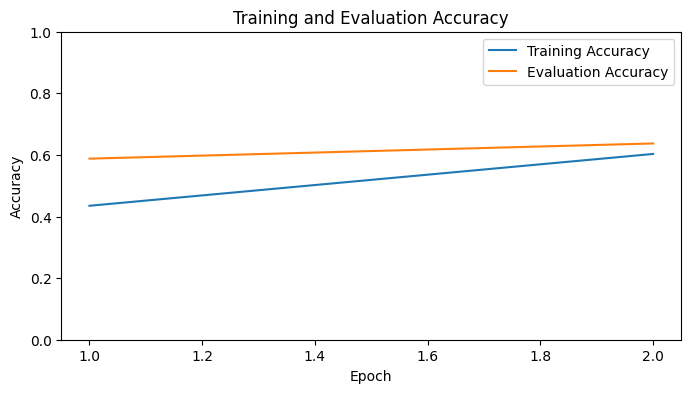

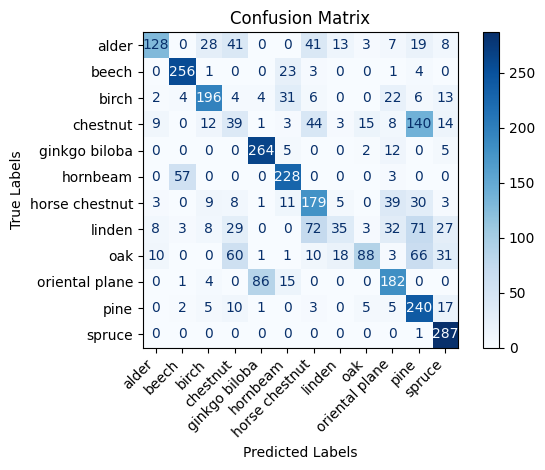


Test Set Evaluation
Accuracy: 0.6140
Precision: 0.6195
Recall: 0.6140
F1-Score: 0.5855
Loss:1.1197


In [14]:
import torch # We're using pytorch
import torchvision
import torch.nn as nn
class BatchNormalizationCNN(torch.nn.Module):
    def __init__(self):
        super(BatchNormalizationCNN, self).__init__()
        self.model = nn.Sequential( #3x40x40
            nn.Conv2d(3, 20, kernel_size=4, padding=2), # 20x40x40
            nn.MaxPool2d(2), # 20x20x20
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Conv2d(20, 40, kernel_size=4, padding=2), # 40x20x20
            nn.MaxPool2d(2), #40x10x10
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.Conv2d(40, 60, kernel_size=4, padding=2), # 60x10x10
            nn.MaxPool2d(2), #60x5x5
            nn.BatchNorm2d(60),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(60*5*5, 50),
            nn.BatchNorm1d(50),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(50, 12) # Multi classification
        )
        
    def forward(self, x):
        return self.model(x)
model = BatchNormalizationCNN()
device = torch.device("cuda")
trainModelAndEvaluate(model, standardized_train_loader, standardized_eval_loader, standardized_test_loader, device, -1, "noEarlyStopping_cnn")

### The results from the model excluding the dataset do not seem to be reflecting the model accurately, let's investigate what happens if we disable early stopping

Epoch [1/2], Training Accuracy: 0.4004, Average Loss: 1.7492 | Evaluation Accuracy: 0.3420 Loss:1.9222
Epoch [2/2], Training Accuracy: 0.5454, Average Loss: 1.3309 | Evaluation Accuracy: 0.4763 Loss:1.6126
Finished training and saved model


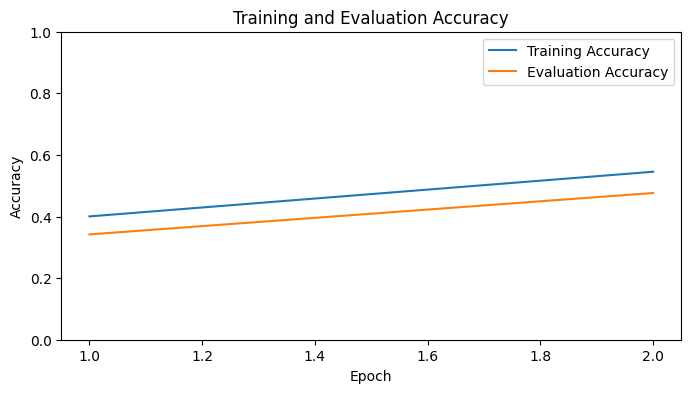

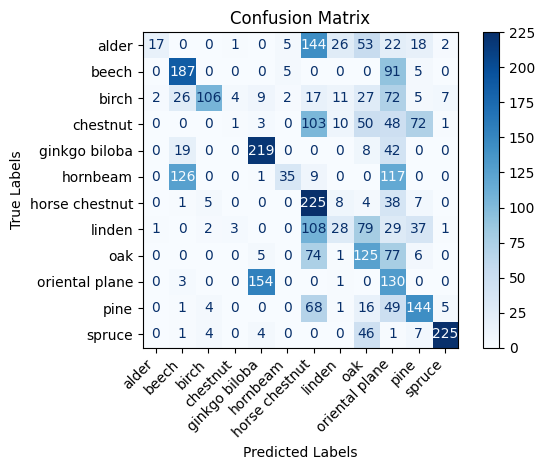


Test Set Evaluation
Accuracy: 0.4172
Precision: 0.5147
Recall: 0.4172
F1-Score: 0.3834
Loss:1.7876


In [15]:
import torch # We're using pytorch
import torchvision
import torch.nn as nn
class BatchNormalizationCNN(torch.nn.Module):
    def __init__(self):
        super(BatchNormalizationCNN, self).__init__()
        self.model = nn.Sequential( #3x40x40
            nn.Conv2d(3, 20, kernel_size=4, padding=2), # 20x40x40
            nn.MaxPool2d(2), # 20x20x20
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Conv2d(20, 40, kernel_size=4, padding=2), # 40x20x20
            nn.MaxPool2d(2), #40x10x10
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.Conv2d(40, 60, kernel_size=4, padding=2), # 60x10x10
            nn.MaxPool2d(2), #60x5x5
            nn.BatchNorm2d(60),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(60*5*5, 50),
            nn.BatchNorm1d(50),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(50, 12) # Multi classification
        )
        
    def forward(self, x):
        return self.model(x)
model = BatchNormalizationCNN()
device = torch.device("cuda")
trainModelAndEvaluate(model, train_loader, eval_loader, test_loader, device, -1, "inconclusive")

### let's visualize a subset of correct and incorrect predictions on images

In [16]:
# Load final model
model = BatchNormalizationCNN()
model.load_state_dict(torch.load("full_cnn.pth"))
model.to(device)

BatchNormalizationCNN(
  (model): Sequential(
    (0): Conv2d(3, 20, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(20, 40, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(40, 60, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=1500, out_features=50, bias=True)
    (14): BatchNorm1d(50, eps=1e-05, momentum=0.1, affi

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


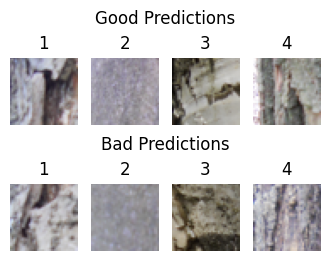

In [17]:
# Some sloppy code just to print one image in a very specific scenario...
# We should be able to visualize 12 image pairs, one pair for each class
def GetGoodBadImagePairs(model, valLoader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_images = []
    total_loss = 0.0
    # Perform predictions on whole dataset
    with torch.no_grad():
        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Pass inputs through model
            outputs = model(inputs)
            # Predict maximum value as predicted class
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(inputs.cpu().numpy())
    # Try to find one good prediction and one bad prediction from each class
    index = 0
    goodBadImagePairs = []

    for classLabel in range(len(set(all_preds))):
        goodPredictionImage = None
        badPredictionImage = None
        # find a good and bad pair from the current class if they exist, otherwise the class is skipped
        while index < len(all_labels) and all_labels[index] == classLabel:
            # Check if the prediction is good
            if goodPredictionImage is None and all_preds[index] == all_labels[index]:
                goodPredictionImage = all_images[index]
            # Check if the prediction is bad
            if badPredictionImage is None and all_preds[index] != all_labels[index]:
                badPredictionImage = all_images[index]
            index += 1
            # If the good-bad pair is found, continue to the next class label
            if goodPredictionImage is not None and badPredictionImage is not None:
                goodBadImagePairs.append([goodPredictionImage,badPredictionImage,classLabel])
                # Fast forward index to the index of the next class label
                while index < len(all_labels) and all_labels[index] == classLabel:
                    index +=1
                index += 1
                break
            
    return goodBadImagePairs

goodBadImagePairs = GetGoodBadImagePairs(model, standardized_test_loader, device)
# Display a number of image pairs as defined in GetGoodBadImagePairs, with good images in a row ontop of bad images, displays class labels
def DisplayImagePairs(image_pairs):
    num_pairs = 4
    # Create a figure with columns equal to the number of pairs and two rows
    fig, axs = plt.subplots(2, num_pairs, figsize=(num_pairs, 3))
    # Plot each pair of images
    for i, (good_img, bad_img, class_label) in enumerate(image_pairs):
        if(i>=num_pairs):
            break
        good_img = np.transpose(good_img, (1, 2, 0))
        bad_img = np.transpose(bad_img, (1, 2, 0))

        # Add back mean and std
        good_img = (good_img * std + mean) / 255
        bad_img = (bad_img * std + mean) / 255

        # Display the good image on first row
        axs[0, i].imshow(good_img)
        axs[0, i].set_title(f"{class_label+1}")
        axs[0, i].axis("off")

        # Display the bad image on second row
        axs[1, i].imshow(bad_img)
        axs[1, i].set_title(f"{class_label+1}")
        axs[1, i].axis("off")
    # Add a title to each row
    axs[0][0].annotate("Good Predictions", xy=(2.3, 1.5), xytext=(0, 0),
                       xycoords="axes fraction", textcoords="offset points",
                       ha="center", va="baseline", fontsize=12)
    axs[1][0].annotate("Bad Predictions", xy=(2.3, 1.5), xytext=(0, 0),
                       xycoords="axes fraction", textcoords="offset points",
                       ha="center", va="baseline", fontsize=12)
    plt.savefig("goodBadPredictions.pdf")
    plt.show()

DisplayImagePairs(goodBadImagePairs)

### Advanced part - let's try to use this network to produce features on cocoa fruits and coffee beans, which we can fit a K-Means clustering algorithm to the model output as an unsupervised learning method

In [18]:
import torch # We're using pytorch
import torchvision
import torch.nn as nn
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning) # Some annoying warning about class ambiguity
# Load final model
model = BatchNormalizationCNN()
model.load_state_dict(torch.load("full_cnn.pth"))
model.to(device)
model.eval()

# Define a function to extract features from the model
def extractFeatures(model, images):
    # standardize the images with the previously calculated values manually
    std = [36.55354537, 37.87313231, 39.76296257]
    mean = [143.47162666, 139.36865102, 133.09146855]
    standardized_images = []
    for image in images:
        standardized_image = (image - mean)/std
        standardized_image = torch.tensor(standardized_image, dtype=torch.float32).to(device)
        standardized_image = standardized_image.permute(2,0,1)
        standardized_images.append(standardized_image)
    features = []
    with torch.no_grad():
        for image in standardized_images:
            # Pass the image through the model
            output = model(image.unsqueeze(0))  # Add a batch dimension of 1
            # Add "features" from the output layer to a list
            features.append(output.squeeze().cpu().numpy())
    return np.array(features)

In [20]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA # To visualize the clusters

# Extract "features" from the images (the outputs of the model)
features = extractFeatures(model, ood_id_images)
# Fit two k-means clusters to the 12 dimensional data
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(features)
# Get prediction accuracy on the training data (assuming we don't need to swap the labels around)
print(f"Accuracy of predictions: {100*np.sum(np.array(kmeans.labels_) == np.array(ood_id_labels))/len(ood_id_labels)}%")

Accuracy of predictions: 95.3%


### let's visualize the resulting classifications

Text(50.847222222222214, 0.5, 'Frequency')

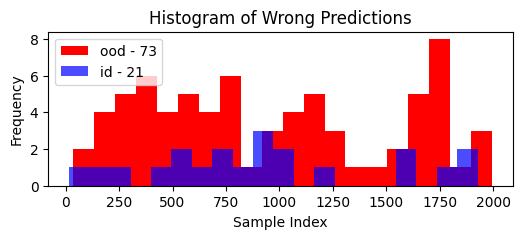

In [21]:
# Get indeces of bad predictions for each class
bad_id_predictions_indeces = [i for i, n in enumerate(kmeans.labels_) if n == 1 and n != ood_id_labels[i]]
bad_ood_predictions_indeces = [i for i, n in enumerate(kmeans.labels_) if n == 0 and n != ood_id_labels[i]]
# Plot the distributions of bad predictions from the kmeans model
plt.figure(figsize=(6, 2))
plt.title("Histogram of Wrong Predictions")
plt.hist(np.array(bad_ood_predictions_indeces), bins=20, color="red", alpha=1,label=f"ood - {len(bad_ood_predictions_indeces)}")
plt.hist(np.array(bad_id_predictions_indeces), bins=20, color="blue",alpha=0.7,label=f"id - {len(bad_id_predictions_indeces)}")
plt.legend(loc="upper left")
plt.savefig("predictionHistogram.pdf")
plt.xlabel("Sample Index")
plt.ylabel("Frequency")



21


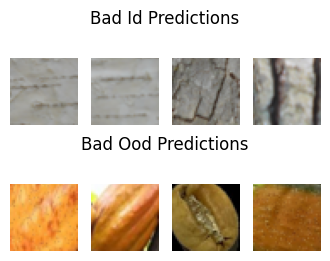

In [22]:
# let's plot some of the wrong predictions
def DisplayBadIdOodImagePairs(image_pairs):
    # Create a figure with rows equal to the number of pairs and two columns
    fig, axs = plt.subplots(2, 4, figsize=(4, 3))
    # Plot each pair of images
    for i, (id_img, ood_img) in enumerate(image_pairs):
        # Display id on top row
        axs[0, i].imshow(id_img)
        axs[0, i].axis("off")
        # Display ood on bottom row
        axs[1, i].imshow(ood_img)
        axs[1, i].axis("off")
    # Display titles for each row
    axs[0][0].annotate("Bad Id Predictions", xy=(2.3, 1.5), xytext=(0, 0),
                       xycoords="axes fraction", textcoords="offset points",
                       ha="center", va="baseline", fontsize=12)
    axs[1][0].annotate("Bad Ood Predictions", xy=(2.3, 1.5), xytext=(0, 0),
                       xycoords="axes fraction", textcoords="offset points",
                       ha="center", va="baseline", fontsize=12)
    plt.savefig("badIdOodPredictions.pdf")
    plt.show()

# Create 4 image id-ood image pairs
bad_id_ood_image_pairs = []
for i in range(4):
    bad_id_index = bad_id_predictions_indeces[i]
    bad_id_img = ood_id_images[bad_id_index]
    bad_ood_index = bad_ood_predictions_indeces[i]
    bad_ood_img = ood_id_images[bad_ood_index]
    bad_id_ood_image_pairs.append([bad_id_img,bad_ood_img])
print(len(bad_id_predictions_indeces))
DisplayBadIdOodImagePairs(bad_id_ood_image_pairs)

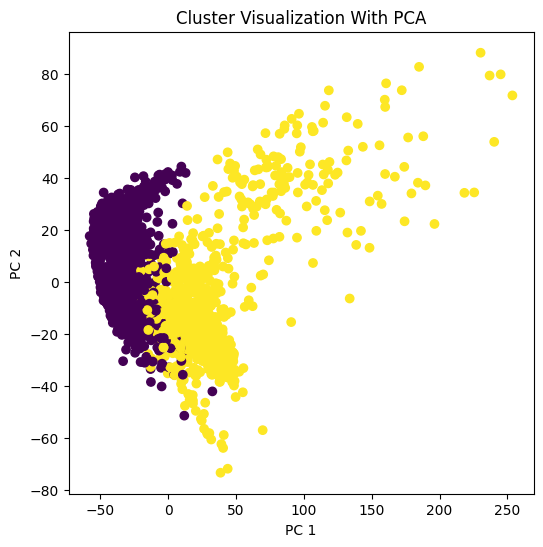

In [23]:
# Fit PCA to reduce dimensionality
pca = PCA(n_components=2)
features_reduced = pca.fit_transform(features)
# Visualize the clusters
plt.figure(figsize=(6, 6))
scatter = plt.scatter(features_reduced[:, 0], features_reduced[:, 1], label=["id","ood"],c=ood_id_labels, cmap="viridis")
plt.title("Cluster Visualization With PCA")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.savefig("PCA.pdf")
plt.show()